# Call Spread with highest probability of profit (PoP)

Call spreads are [vertical spreads](https://www.investopedia.com/terms/v/verticalspread.asp), i.e., two-legged options strategies where the trader buys a call and simultaneously sells another call, both with same expiration but different strikes.

Vertical spreads offer a downside risk floor, contributing to effective risk management, while also capping potential gains.

In this notebook, we conduct a search for the call spread with the highest probability of profit by considering all possible pairs of strikes, with and without a constraint. The underlying asset in focus is Microsoft stock, which was trading at 342.97 on November 22, 2021. The strike, bid price, and ask price of call options expiring on December 17, 2021, are sourced from a CSV file.

For further details on this study, refer to [this article on Medium.com](https://medium.com/@rgaveiga/python-for-options-trading-1-selecting-a-call-spread-with-the-highest-probability-of-profit-8e61c9d325d6)

**Caveat: Options are very risky derivatives and, like any other type of financial vehicle, trading options requires due diligence. Transactions shown as examples of trading strategies with options in this notebook are not recommendations.**

In [1]:
from __future__ import print_function
from optionlab.strategy import Strategy
import pandas as pd
import matplotlib.pyplot as plt
from numpy import zeros
%matplotlib inline

In [2]:
stockprice=342.97
volatility=0.18
startdate="2021-11-22"
targetdate="2021-12-17"
interestrate=0.001
minstock=0.0
maxstock=stockprice+round(stockprice*0.5,2)

In [3]:
df=pd.read_csv("msft_22-November-2021.csv")
chain=[]

for i,_ in enumerate(df["Expiration"]):
    if df["Expiration"][i]==targetdate and df["Type"][i]=="call":
        chain.append([df["Strike"][i],
                      df["Bid"][i],
                      df["Ask"][i]])

In [4]:
st=Strategy()

### Unconstrained:

In [5]:
def get_highest_pop():
  maxpop=0.0

  for i in range(len(chain)-1):
      for j in range(i+i,len(chain)):
          for k in (("sell","buy"),("buy","sell")):
              if k[0]=="sell":
                  premium=[chain[i][1],chain[j][2]]
              else:
                  premium=[chain[i][2],chain[j][1]]
            
              strategy=[{"type":"call","strike":chain[i][0],"premium":premium[0],"n":100,"action":k[0]},
                        {"type":"call","strike":chain[j][0],"premium":premium[1],"n":100,"action":k[1]}]

              st.getdata(stockprice=stockprice,startdate=startdate,
                         targetdate=targetdate,volatility=volatility,
                         interestrate=interestrate,minstock=minstock,
                         maxstock=maxstock,strategy=strategy)

              out=st.run()
              
              if maxpop<out["ProbabilityOfProfit"]:
                  maxpop=out["ProbabilityOfProfit"]
                  best_strategy=strategy

  return best_strategy

In [6]:
%%time
best_strategy=get_highest_pop()

CPU times: total: 5.05 s
Wall time: 5.05 s


In [7]:
print(best_strategy)

[{'type': 'call', 'strike': 145.0, 'premium': 198.05, 'n': 100, 'action': 'buy'}, {'type': 'call', 'strike': 305.0, 'premium': 38.1, 'n': 100, 'action': 'sell'}]


In [8]:
st.getdata(stockprice=stockprice,startdate=startdate,
           targetdate=targetdate,volatility=volatility,
           interestrate=interestrate,minstock=minstock,
           maxstock=maxstock,strategy=best_strategy)

out=st.run()

In [9]:
print("Days remaining to the target date: %d" % st.days2target)
print("Strategy cost: %.2f" % out["StrategyCost"])
print("Maximum loss: %.2f" % abs(out["MinimumReturnInTheDomain"]))
print("Maximum profit: %.2f" % out["MaximumReturnInTheDomain"])
print("Profitable stock price range:")

for profrange in out["ProfitRanges"]:
    print("      %.2f ---> %.2f" % (profrange[0],profrange[1]))

print("Probability of Profit (PoP): %.1f%%" % (out["ProbabilityOfProfit"]*100.0))

Days remaining to the target date: 18
Strategy cost: -15995.00
Maximum loss: 15995.00
Maximum profit: 5.00
Profitable stock price range:
      304.96 ---> inf
Probability of Profit (PoP): 99.2%


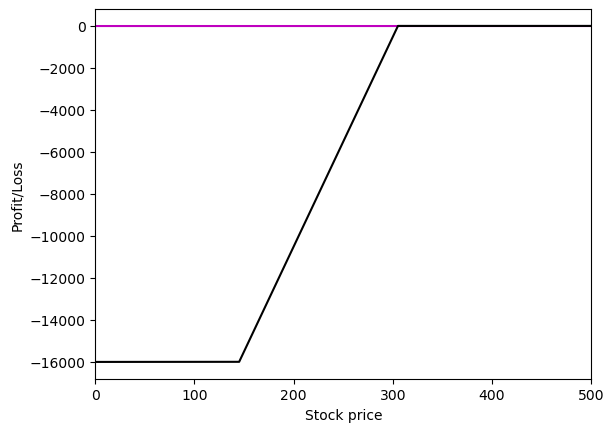

In [10]:
s,pl_total=st.getPL()
zeroline=zeros(s.shape[0])
plt.xlabel("Stock price")
plt.ylabel("Profit/Loss")
plt.xlim(0,500)
plt.plot(s,zeroline,'m-')
plt.plot(s,pl_total,'k-')

### Constrained (maximum profit/minimum loss ratio greater than or equal to 1):

In [11]:
def get_highest_pop():
  maxpop=0.0

  for i in range(len(chain)-1):
      for j in range(i+i,len(chain)):
          for k in (("sell","buy"),("buy","sell")):
              if k[0]=="sell":
                  premium=[chain[i][1],chain[j][2]]
              else:
                  premium=[chain[i][2],chain[j][1]]
            
              strategy=[{"type":"call","strike":chain[i][0],"premium":premium[0],"n":100,"action":k[0]},
                        {"type":"call","strike":chain[j][0],"premium":premium[1],"n":100,"action":k[1]}]

              st.getdata(stockprice=stockprice,startdate=startdate,
                         targetdate=targetdate,volatility=volatility,
                         interestrate=interestrate,minstock=minstock,
                         maxstock=maxstock,strategy=strategy)

              out=st.run()
              
              if abs(out["MaximumReturnInTheDomain"]/out["MinimumReturnInTheDomain"])>=1.0:
                  if maxpop<out["ProbabilityOfProfit"]:
                    maxpop=out["ProbabilityOfProfit"]
                    best_strategy=strategy

  return best_strategy

In [12]:
%%time
best_strategy=get_highest_pop()

CPU times: total: 4.91 s
Wall time: 4.93 s


In [13]:
print(best_strategy)

[{'type': 'call', 'strike': 260.0, 'premium': 83.0, 'n': 100, 'action': 'buy'}, {'type': 'call', 'strike': 430.0, 'premium': 0.07, 'n': 100, 'action': 'sell'}]


In [14]:
st.getdata(stockprice=stockprice,startdate=startdate,
           targetdate=targetdate,volatility=volatility,
           interestrate=interestrate,minstock=minstock,
           maxstock=maxstock,strategy=best_strategy)

out=st.run()

In [15]:
print("Days remaining to the target date: %d" % st.days2target)
print("Strategy cost: %.2f" % out["StrategyCost"])
print("Maximum loss: %.2f" % abs(out["MinimumReturnInTheDomain"]))
print("Maximum profit: %.2f" % out["MaximumReturnInTheDomain"])
print("Profitable stock price range:")

for profrange in out["ProfitRanges"]:
    print("      %.2f ---> %.2f" % (profrange[0],profrange[1]))

print("Probability of Profit (PoP): %.1f%%" % (out["ProbabilityOfProfit"]*100.0))

Days remaining to the target date: 18
Strategy cost: -8293.00
Maximum loss: 8293.00
Maximum profit: 8707.00
Profitable stock price range:
      342.94 ---> inf
Probability of Profit (PoP): 49.2%


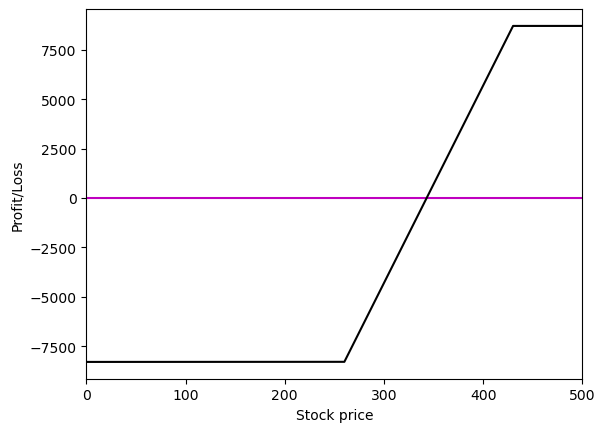

In [16]:
s,pl_total=st.getPL()
zeroline=zeros(s.shape[0])
plt.xlabel("Stock price")
plt.ylabel("Profit/Loss")
plt.xlim(0,500)
plt.plot(s,zeroline,'m-')
plt.plot(s,pl_total,'k-')